In [1]:
from tensorflow.keras.models import load_model
import joblib

model_dir = 'model_data'

model_name1 = 'Seq_2Layer_32_64_ReLU_Adam'
model_name2 = 'Deep_3Layer_64_128_64_ReLU_Adam'
model_name3 = 'Deep_3Layer_128_256_128_ReLU_Adam'

sel_model = model_name2

# Load the model
model_path = f'{model_dir}/{sel_model}/model.keras'
model = load_model(model_path)

# Load the label encoder
le_path = f'{model_dir}/{sel_model}/label_encoder.joblib'
le = joblib.load(le_path)

folds = 5

2024-05-08 19:17:18.736416: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-08 19:17:18.738860: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-08 19:17:18.777892: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 19:17:19.447202: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


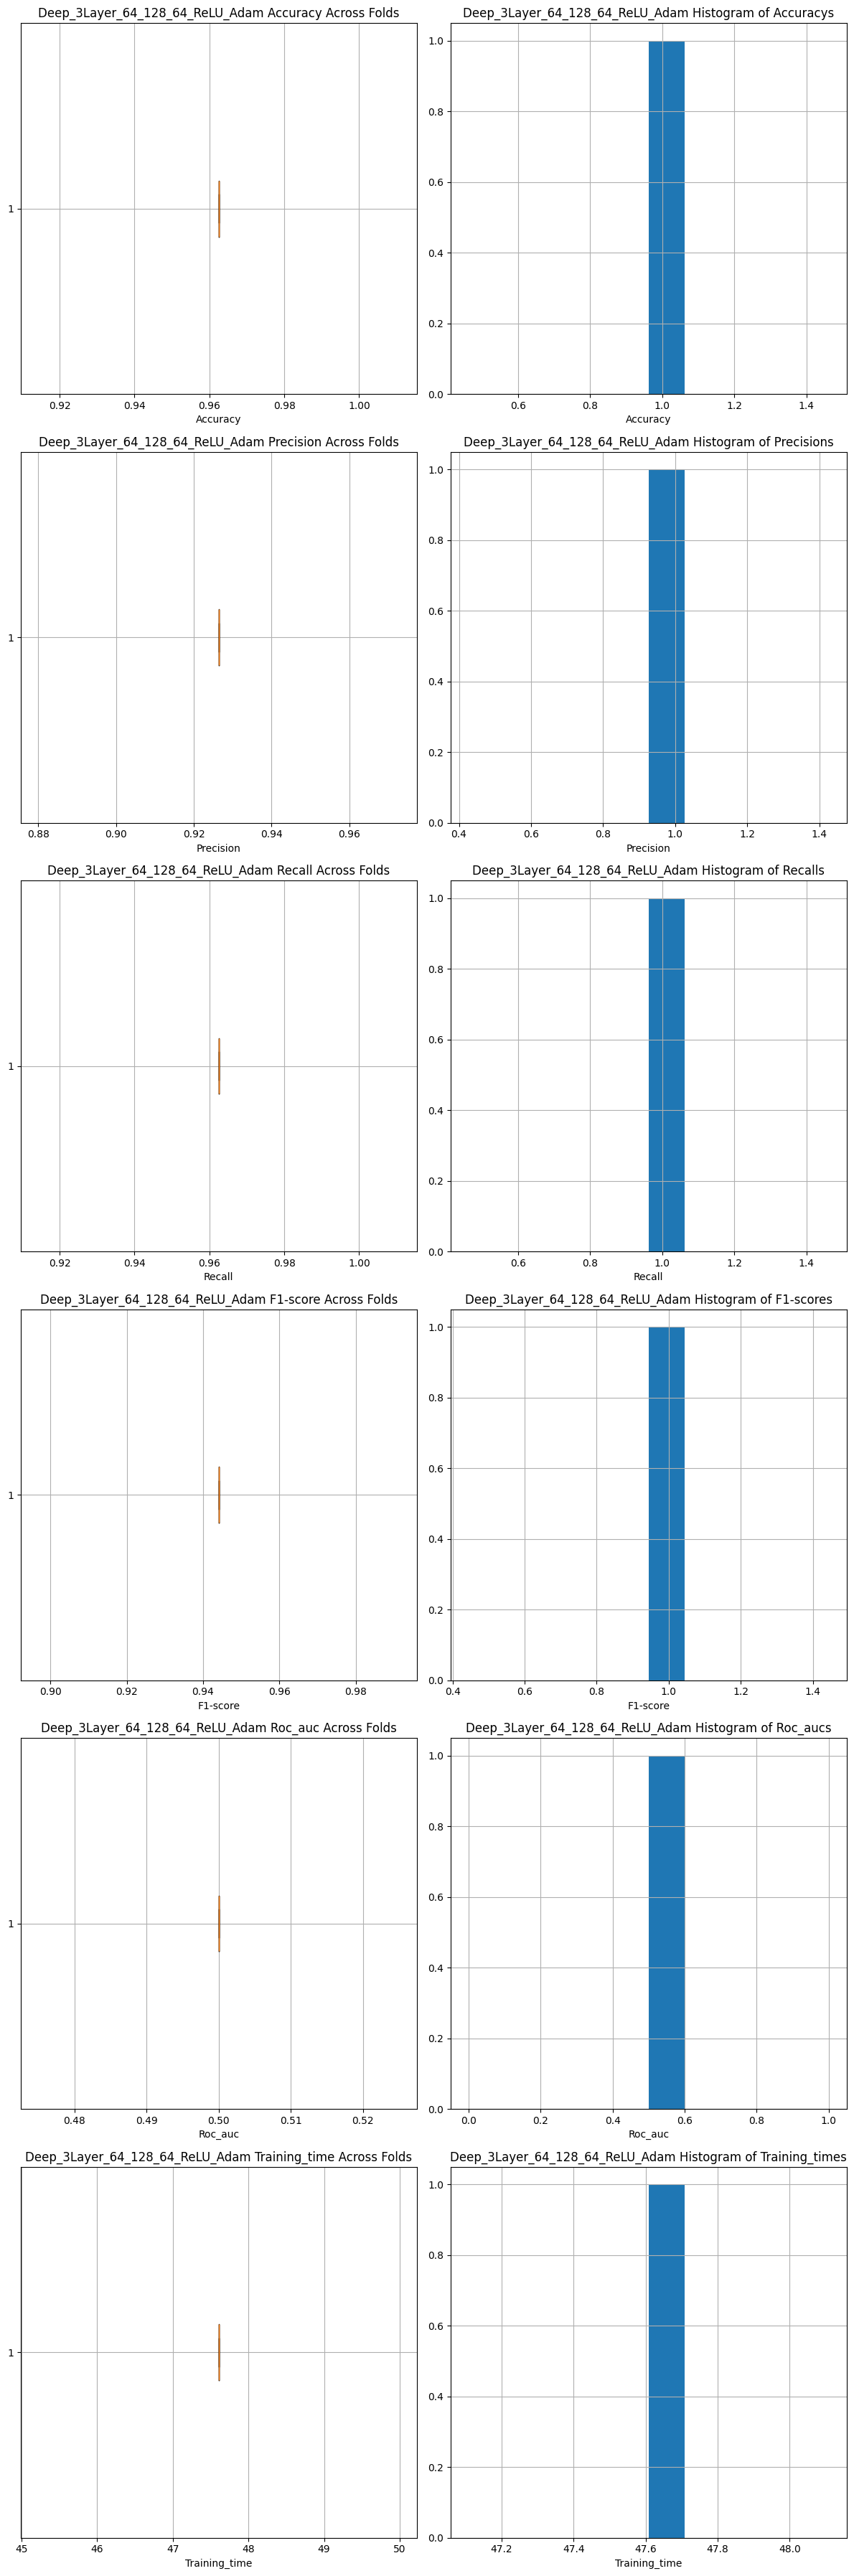

In [2]:
from plotting import plot_metrics
from evaluation import evaluate_and_append_accuracy

for fold in range(1, folds + 1):
    # Load the test data
    test_data_path = f'{model_dir}/{sel_model}/test_data_fold_{fold}.joblib'
    X_test, y_test_categorical = joblib.load(test_data_path)
    
    # Evaluate the model
    metrics = []
    evaluate_and_append_accuracy(model, sel_model, X_test, y_test_categorical, metrics, fold)
    

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - accuracy: 0.9638 - loss: 0.1841
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - accuracy: 0.9638 - loss: 0.1843
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - accuracy: 0.9638 - loss: 0.1843
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - accuracy: 0.9638 - loss: 0.1847
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.9638 - loss: 0.1844
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.9638 - loss: 0.1846
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - accuracy: 0.9638 - loss: 0.1846
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.9638 - loss: 0.1843
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - accuracy: 0.9638 - loss: 0.1844
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - accuracy: 0.9638 - loss: 0.1845
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - accuracy: 0.9638 - loss: 0.1841
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - accuracy: 0.9638 - loss: 0.1840
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.9638 - loss: 0.1840
63/63 ━━━━━━━━━━━━━━━━━━━

(None, None, None)

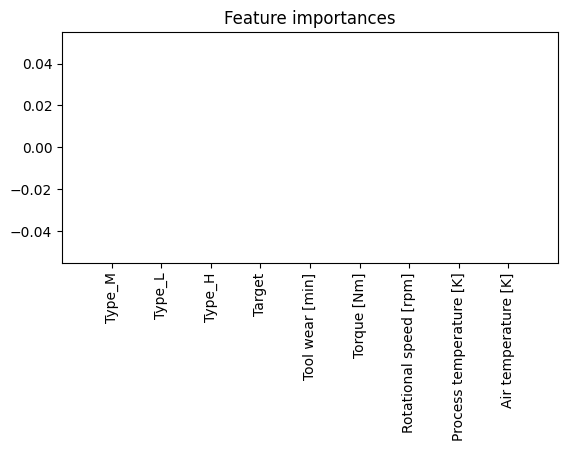

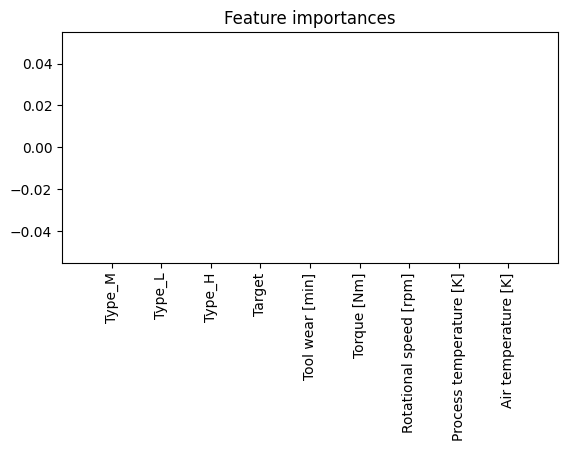

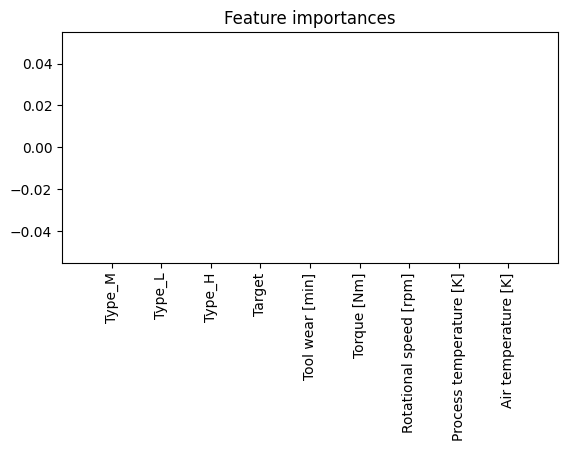

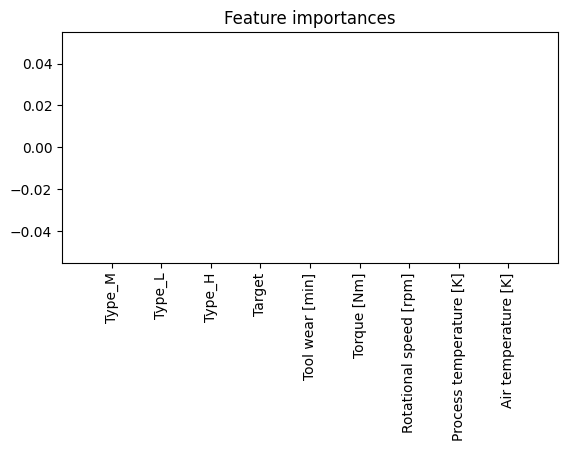

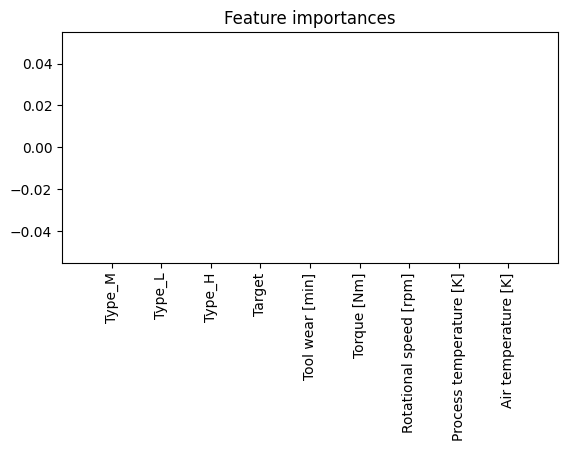

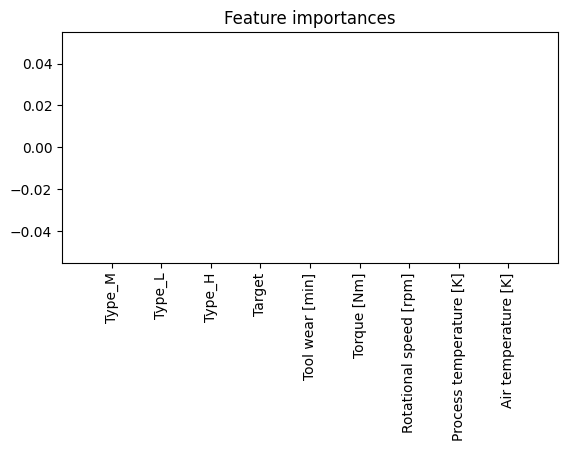

In [2]:
# Explainability with Permutation Feature Importance

from explainabilty import explain_model_with_pfi, keras_score

# Initialize lists to store importances and standard deviations for each fold
all_importances = []
all_std = []

for fold in range(1, folds + 1):
    # Load the test data
    test_data_path = f'{model_dir}/{sel_model}/test_data_fold_{fold}.joblib'
    X_test, y_test_categorical = joblib.load(test_data_path)
    
    # Get feature names
    feature_names = X_test.columns

    # Explain the model with Permutation Feature Importance
    importances, std, indices = explain_model_with_pfi(model, sel_model, X_test, y_test_categorical, fold, keras_score, feature_names, all_importances=all_importances, all_std=all_std)

    # Append the importances and standard deviations to the lists
    all_importances.append(importances)
    all_std.append(std)
    
# After the cross-validation loop, generate the combined plot
explain_model_with_pfi(None, sel_model, None, None, None, None, feature_names, all_importances=all_importances, all_std=all_std)